In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from graphviz import Graph, Digraph

In [77]:
def preset_decision(input_vector): # dim(IV) = 3 -> [L, F. R]
    if np.linalg.norm(input_vector) < 1.5: # sqrt(2)=1.414
        return 3
        
    if input_vector[0] > 0:
        return 2
    elif input_vector[2] > 0:
        return 1
    elif input_vector[1] > 0:
        return 0

In [159]:
class Network:
    def __init__(self, NN_shape):
        self.NN_shape = NN_shape

        self._initialise_parameters()
        self._build_network()

    def _initialise_parameters(self):
        self._weight_input_hidden_size = self.NN_shape[0] * self.NN_shape[1]
        self._bias_hidden_size = self.NN_shape[1]
        self._weight_hidden_output_size = self.NN_shape[1] * self.NN_shape[2]
        self._bias_output_size = self.NN_shape[2]

        self._full_parameter_size = self._weight_input_hidden_size + self._bias_hidden_size + self._weight_hidden_output_size + self._bias_output_size
        
        self._parameters = np.random.randint(low=1, high=100, size=(self._full_parameter_size,))
    
    def _build_network(self):
        self.weight_input_hidden = self._parameters[:self._weight_input_hidden_size].reshape((self.NN_shape[0], self.NN_shape[1]))
        self.bias_hidden = self._parameters[self._weight_input_hidden_size: self._weight_input_hidden_size+self._bias_hidden_size].reshape((self.NN_shape[1],))
        self.weight_hidden_output = self._parameters[self._weight_input_hidden_size+self._bias_hidden_size:self._weight_input_hidden_size+self._bias_hidden_size+self._weight_hidden_output_size].reshape((self.NN_shape[1], self.NN_shape[2]))
        self.bias_output = self._parameters[self._weight_input_hidden_size+self._bias_hidden_size+self._weight_hidden_output_size:].reshape((self.NN_shape[2],))

    @staticmethod
    def _calc_mse(x, y):
        return np.mean((x-y)**2)

    def feed_forward(self, input_values):
        self.input = np.array(input_values)
        self.hidden = np.dot(self.input, self.weight_input_hidden) + self.bias_hidden
        self.output = np.dot(self.hidden, self.weight_hidden_output) + self.bias_output
        self.output_normalised = self.output / np.linalg.norm(self.output)

        self.decision = np.argmax(self.output_normalised, axis=1)

    def train_montecarlo(self, input_data, ground_truth, *, max_iter=10000):
        mse = []
        self.feed_forward(input_values=input_data)
        curr_mse = self._calc_mse(self.output_normalised, ground_truth)
        mse.append(curr_mse)

        self._parameters_backup = np.copy(self._parameters)        
        self._parameters[np.random.randint(self._full_parameter_size)] = np.random.randint(low=1, high=6)
        self._build_network()
        for curr_iter in tqdm(range(1, max_iter+1)):
            self.feed_forward(input_values=input_data)
            curr_mse = self._calc_mse(self.output_normalised, ground_truth)
            mse.append(curr_mse)

            if curr_mse < mse[curr_iter-1]:
                self._parameters_backup = np.copy(self._parameters)
                self._parameters[np.random.randint(self._full_parameter_size)] = np.random.randint(low=1, high=6)
                self._build_network()
            else:
                self._parameters = np.copy(self._parameters_backup)
                self._build_network()
            
        return(mse)

In [160]:
my_network = Network((3, 2, 4))

decision_dict = dict([
    (0, np.array([0, 1])),
    (1, np.array([1, 0])),
    (2, np.array([1, 0])),
    (3, 'Explode'),
])

In [164]:
train_size = int(1e4)

train_lateral = np.random.randint(low=-10, high=10, size=train_size)
train_y = np.random.randint(low=0, high=10, size=train_size)
train_L = -np.clip(train_lateral, -10, 0)
train_R = np.clip(train_lateral, 0, 10)

train_inputs = np.array(list(zip(train_L, train_y, train_R)))
train_decision_matrix = np.array([np.eye(4)[preset_decision(vector)] for vector in train_inputs])

mse = my_network.train_montecarlo(train_inputs, train_decision_matrix, max_iter=10000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.68it/s]


In [165]:
print(my_network.output)
print(my_network.decision)

[[ 2189 41480 45926  3079]
 [ 1829 32300 36062  2215]
 [ 2065 36984 41222  2579]
 ...
 [ 1307 24992 27638  1873]
 [ 2537 46352 51542  3307]
 [ 1929 28180 32270  1443]]
[2 2 2 ... 2 2 2]


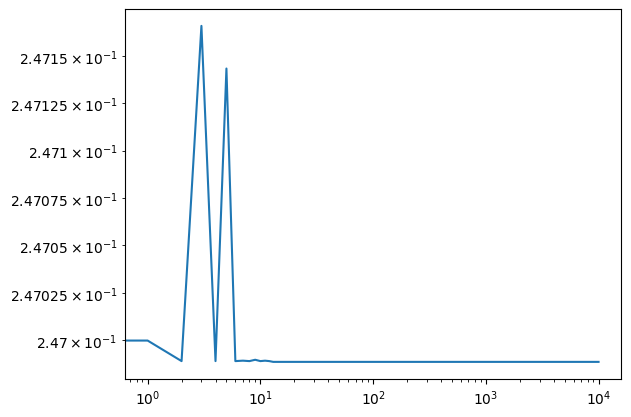

In [166]:
fig, ax = plt.subplots()
ax.plot(mse)
# ax.set_ylim(bottom=0, top=1)
ax.set_yscale('log')
ax.set_xscale('log')